### Reglas de Asociación

Librerias

In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import json
from scipy import stats
from fitter import Fitter, get_common_distributions
from datetime import datetime
import datetime as dt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from matplotlib import style
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
style.use('ggplot') or plt.style.use('ggplot')
%matplotlib inline
import matplotlib.font_manager
#from shapely.geometry import shape, Point
from plotnine import *

In [4]:
# Librerias para el modelo apriori(reglas de asociacion por items)
from mlxtend.frequent_patterns import apriori 
from mlxtend.frequent_patterns import association_rules
from imblearn.ensemble import BalancedBaggingClassifier


#### Modelo Apriori

In [6]:
ventasP = pd.read_csv ('Datos_2020.csv', delimiter=';')

In [7]:
ventasP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188526 entries, 0 to 188525
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   FECHA              188526 non-null  object 
 1   CANAL              188526 non-null  object 
 2   FACTURA            188526 non-null  object 
 3   Id_Cliente         188526 non-null  int64  
 4   PROVINCIA_CLIENTE  188526 non-null  object 
 5   CIUDAD_CLIENTE     188526 non-null  object 
 6   des_estado_civil   188526 non-null  object 
 7   des_sexo           188526 non-null  object 
 8   EDAD               182302 non-null  float64
 9   FORMA_PAGO         188526 non-null  object 
 10  MEDIO_PAGO         188526 non-null  object 
 11  LINEA              188526 non-null  object 
 12  GRUPO              188526 non-null  object 
 13  MARCA              188526 non-null  object 
 14  COD_PRODUCTO       188526 non-null  object 
 15  PRODUCTO           188526 non-null  object 
 16  UN

In [8]:
# Tipo string las variables Factura y Grupo de Producto
ventasP['GRUPO'] = ventasP['GRUPO'].str.strip()
ventasP.dropna(axis=0, subset=['FACTURA'],inplace=True)
ventasP['FACTURA']= ventasP['FACTURA'].astype('str')

In [9]:
# se crea la data, transacciones por items
basket = (ventasP.groupby(['FACTURA','GRUPO'])['UNIDADES_VENDIDAS']
                .sum().unstack().reset_index().fillna(0)
                .set_index('FACTURA'))

In [10]:
# Soporte para cada items
frequent_itemsets = apriori(basket > 0, min_support=0.001,use_colnames=True).sort_values(by = 'support', ascending = False)
frequent_itemsets.head()

,support,itemsets
57,0.202792,(TELEVISORES)
59,0.113735,(VENTILADORES)
48,0.105920,(REFRIGERADORAS)
15,0.091129,(COCINAS)
30,0.087678,(LAVADORAS)


In [11]:
# frecuencia de los itemsets
frequent_itemsets['itemsets_cl'] = frequent_itemsets['itemsets'].astype(str)
frequent_itemsets['itemsets_cl'] = frequent_itemsets['itemsets_cl'].str.replace("frozenset","").str.replace("'","").str.replace("{","").str.replace("(","").str.replace("}","").str.replace(")","")
frequent_itemsets_top = frequent_itemsets.head(10)

<ipython-input-11-19e61dc40d99>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


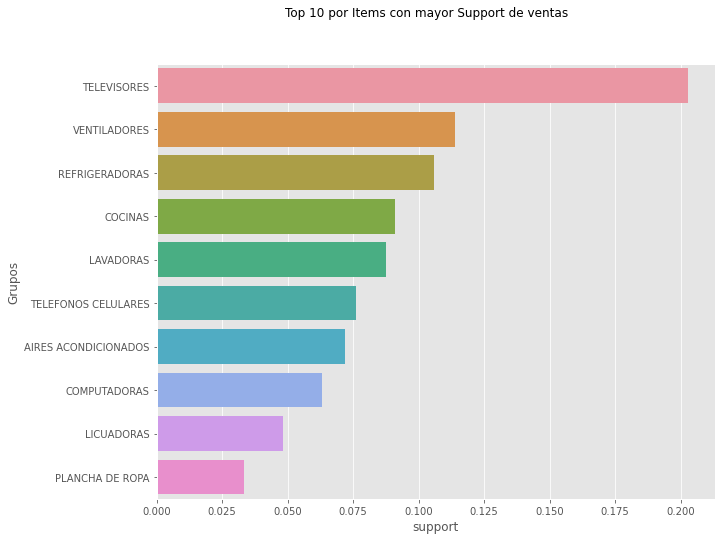

In [12]:
# Grafico
fig,axs = plt.subplots(figsize=(10,8)) 
sns.barplot( data = frequent_itemsets_top , x='support', y='itemsets_cl', orient ="h", 
            order=frequent_itemsets_top.sort_values('support',ascending = False).itemsets_cl)
_=plt.xlabel("support")
_=plt.ylabel("Grupos")
_=plt.suptitle("Top 10 por Items con mayor Support de ventas")

In [13]:
# Comentario:
# support.- El soporte se refiere a la popularidad predeterminada de un items en particular (% de participacion).
#           se calcula: el # de transacciones que contiene el itmes / el # total de las transacciones.

In [14]:
frequent_itemsets.describe()

,support
count,175.000000
mean,0.009212
std,0.023054
min,0.001007
25%,0.001354
50%,0.002452
75%,0.006118
max,0.202792


In [15]:
## Modelo de Reglas de Asociacion (Algoritmo Apriori)
# Reglas con mayor Nro de Confianza.
rules = association_rules(frequent_itemsets, metric="confidence",min_threshold=0.4).sort_values('confidence',ascending = False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
25,"(COLCHONES, SARTEN, COCINAS)",(REFRIGERADORAS),0.001343,0.105920,0.001335,0.994565,9.389789,0.001193,164.510744
26,"(COCINAS, SARTEN, REFRIGERADORAS)",(COLCHONES),0.001350,0.025021,0.001335,0.989189,39.534970,0.001302,90.185593
24,"(COLCHONES, SARTEN, REFRIGERADORAS)",(COCINAS),0.001357,0.091129,0.001335,0.983871,10.796426,0.001212,56.349982
15,"(COLCHONES, SARTEN)",(REFRIGERADORAS),0.001408,0.105920,0.001357,0.963731,9.098676,0.001208,24.651067
21,"(COLCHONES, SARTEN)",(COCINAS),0.001408,0.091129,0.001343,0.953368,10.461703,0.001214,19.490227


In [16]:
rules['rules'] = rules['antecedents'].astype(str) +' --> '+ rules['consequents'].astype(str)
rules = rules.head(10)

In [17]:
rules['rules'] = rules['rules'].str.replace("frozenset","").str.replace("'","").str.replace("{","").str.replace("(","").str.replace("}","").str.replace(")","")
rules.head()

<ipython-input-17-57e656b98586>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
25,"(COLCHONES, SARTEN, COCINAS)",(REFRIGERADORAS),0.001343,0.105920,0.001335,0.994565,9.389789,0.001193,164.510744,"COLCHONES, SARTEN, COCINAS --> REFRIGERADORAS"
26,"(COCINAS, SARTEN, REFRIGERADORAS)",(COLCHONES),0.001350,0.025021,0.001335,0.989189,39.534970,0.001302,90.185593,"COCINAS, SARTEN, REFRIGERADORAS --> COLCHONES"
24,"(COLCHONES, SARTEN, REFRIGERADORAS)",(COCINAS),0.001357,0.091129,0.001335,0.983871,10.796426,0.001212,56.349982,"COLCHONES, SARTEN, REFRIGERADORAS --> COCINAS"
15,"(COLCHONES, SARTEN)",(REFRIGERADORAS),0.001408,0.105920,0.001357,0.963731,9.098676,0.001208,24.651067,"COLCHONES, SARTEN --> REFRIGERADORAS"
21,"(COLCHONES, SARTEN)",(COCINAS),0.001408,0.091129,0.001343,0.953368,10.461703,0.001214,19.490227,"COLCHONES, SARTEN --> COCINAS"


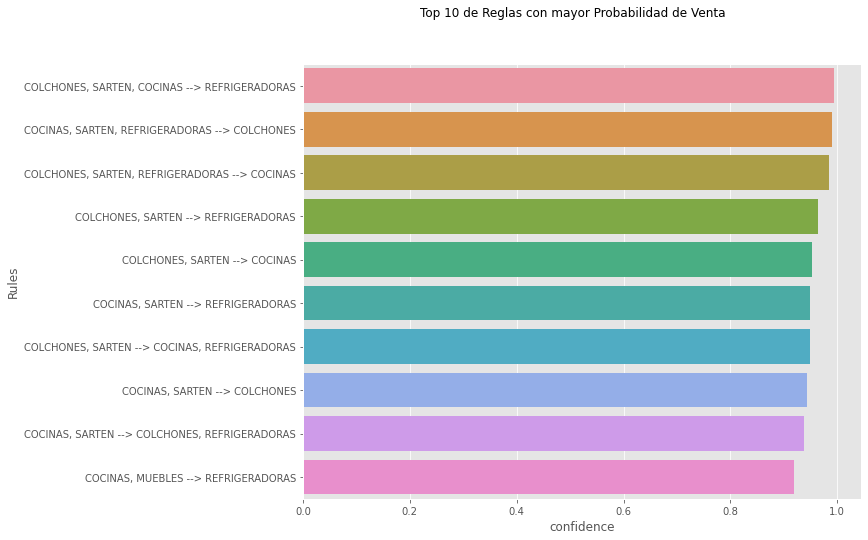

In [18]:
# Grafico
fig,axs = plt.subplots(figsize=(10,8)) 
sns.barplot( data = rules , x='confidence', y='rules', orient ="h", 
            order=rules.sort_values('confidence',ascending = False).rules)
_=plt.xlabel("confidence")
_=plt.ylabel("Rules")
_=plt.suptitle("Top 10 de Reglas con mayor Probabilidad de Venta")

In [19]:
# Comentario:
# confidence.- La confianza se refiere a la probalidad de que compre el articulo A (consequents) dado que compro el articulo B (antecedents).
#              se calcula: transacciones que contiene ambos articulos (A y B) / transacciones que contiene articulo B.

In [20]:
# Comentario:
# Se observa en la tabla que la 1ra regla con mayor confidence es:
# La probabilidad que compre un Televisor dado que compro Sistemas de Audio es 0.77.

In [21]:
## Reglas con mayor participacion de venta.
rules = association_rules(frequent_itemsets, metric="lift",min_threshold=0.2).sort_values('support',ascending = False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(COCINAS),(REFRIGERADORAS),0.091129,0.105920,0.020022,0.219713,2.074336,0.010370,1.145835
1,(REFRIGERADORAS),(COCINAS),0.105920,0.091129,0.020022,0.189033,2.074336,0.010370,1.120724
2,(TELEVISORES),(SISTEMAS DE AUDIO Y VIDEO),0.202792,0.014834,0.009479,0.046740,3.150805,0.006470,1.033470
3,(SISTEMAS DE AUDIO Y VIDEO),(TELEVISORES),0.014834,0.202792,0.009479,0.638957,3.150805,0.006470,2.208071
4,(LAVADORAS),(PLANCHA DE ROPA),0.087678,0.033237,0.008902,0.101531,3.054788,0.005988,1.076012


In [22]:
rules['rules'] = rules['antecedents'].astype(str) +'-->'+ rules['consequents'].astype(str)
rules = rules.head(10)

In [23]:
rules['rules'] = rules['rules'].str.replace("frozenset","").str.replace("'","").str.replace("{","").str.replace("(","").str.replace("}","").str.replace(")","")
rules.head()

<ipython-input-23-57e656b98586>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
0,(COCINAS),(REFRIGERADORAS),0.091129,0.105920,0.020022,0.219713,2.074336,0.010370,1.145835,COCINAS-->REFRIGERADORAS
1,(REFRIGERADORAS),(COCINAS),0.105920,0.091129,0.020022,0.189033,2.074336,0.010370,1.120724,REFRIGERADORAS-->COCINAS
2,(TELEVISORES),(SISTEMAS DE AUDIO Y VIDEO),0.202792,0.014834,0.009479,0.046740,3.150805,0.006470,1.033470,TELEVISORES-->SISTEMAS DE AUDIO Y VIDEO
3,(SISTEMAS DE AUDIO Y VIDEO),(TELEVISORES),0.014834,0.202792,0.009479,0.638957,3.150805,0.006470,2.208071,SISTEMAS DE AUDIO Y VIDEO-->TELEVISORES
4,(LAVADORAS),(PLANCHA DE ROPA),0.087678,0.033237,0.008902,0.101531,3.054788,0.005988,1.076012,LAVADORAS-->PLANCHA DE ROPA


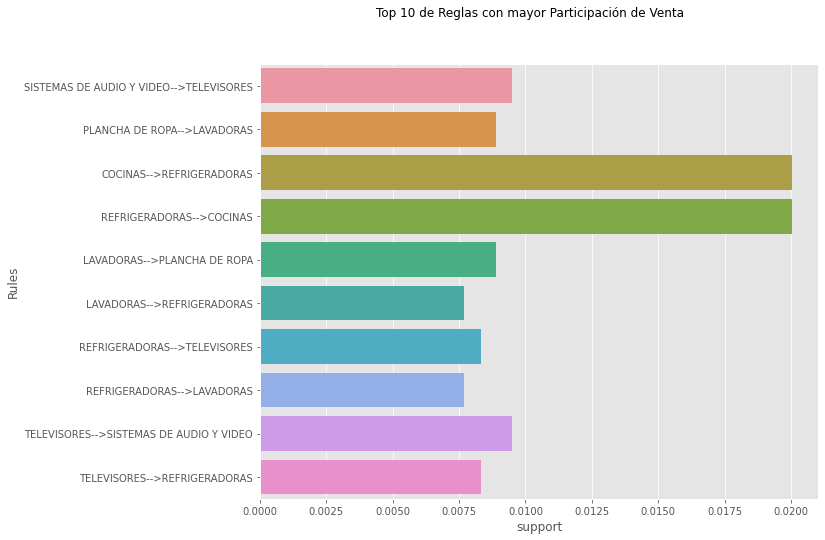

In [24]:
# Grafico
fig,axs = plt.subplots(figsize=(10,8)) 
sns.barplot( data = rules , x='support', y='rules', orient ="h", 
            order=rules.sort_values('confidence',ascending = False).rules)
_=plt.xlabel("support")
_=plt.ylabel("Rules")
_=plt.suptitle("Top 10 de Reglas con mayor Participación de Venta")

In [25]:
# Comentario:
# Se observa en la tabla que la 1ra regla con mayor partipacion de venta es:
# La combinacion entre Televisores y sistemas de audio y video son las mas vendidas 